<a href="https://colab.research.google.com/github/ariqnfl/ds_project/blob/main/CrediBook_App_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install -qq google-play-scraper

In [96]:
!pip install emoji

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49717 sha256=2dec2c6bffd8a3ae1a82bab439a1132105f024cd22baf7905847e83bcb4446e9
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


In [157]:
# import library
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import emoji

import matplotlib.pyplot as plt

from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, reviews_all, app

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.options.mode.chained_assignment = None 
pd.options.display.max_colwidth=200

In [50]:
# Obtain the app id from the respective google play store page
ap = 'com.credibook.app'

Ada 2 dataset yaitu App Information & App Reviews

# App Infos

Obtain app informations such as histogram of ratings, rating score, app description, genre, etc

In [51]:
app_infos = []

info = app(ap, lang='id', country='id')
del info['comments']
app_infos.append(info)

In [52]:
app_info_df = pd.DataFrame([app_infos[0]])
app_info_df

,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,saleTime,originalPrice,saleText,offersIAP,inAppProductPrice,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,editorsChoice,appId,url
0,CrediBook - Catatan Keuangan Harian dan Pembukuan,CrediBook adalah aplikasi keuangan digital yang memiliki fitur catatan keuangan harian dan pembukuan yang cocok digunakan untuk UMKM maupun bisnis / usaha lainnya. Catatan keuangan CrediBook cocok...,CrediBook adalah aplikasi keuangan digital yang memiliki fitur catatan keuangan harian dan pembukuan yang cocok digunakan untuk UMKM maupun bisnis / usaha lainnya. Catatan keuangan CrediBook cocok...,"Catatan keuangan, pembukuan, laporan keuangan, catatan hutang, catatan transaksi","Catatan keuangan, pembukuan, laporan keuangan, catatan hutang, catatan transaksi",100.000+,100000,4.519531,5039,2392,"[305, 98, 206, 492, 3938]",0,True,USD,False,None,None,None,False,None,26M,5.0,5.0 dan yang lebih tinggi,PT Ruang Dagang Internasional,PT+Ruang+Dagang+Internasional,contact@credibook.com,https://credibook.com,None,https://credibook.com/privacy,5257063016087304781,Bisnis,BUSINESS,https://play-lh.googleusercontent.com/MZ0TtXaF6UokNBSS1A7fX5NNRhQyyYl2BPgYcor9lCIRSGtpjdZCUdN-fkeXUS45UQc,https://play-lh.googleusercontent.com/8h1WDKhF6MD8GfOEp9E1tp9pJQ22zVWZioD3pUoHpafVpeHH8iaJPCnbponDDcpVVvbM,"[https://play-lh.googleusercontent.com/MGPI55PDwA7W3C5t9bn7HfKIJIt_fCAYVY8z3Nhcfo2mPpE32tywN5_09gx8oH1INg, https://play-lh.googleusercontent.com/bvWdDVRcREkea_quUVT5UxYUCLp-4qa7opNmlwbc64fcQEHHdTX...",https://www.youtube.com/embed/o8q02Lvc7S8?ps=play&vq=large&rel=0&autohide=1&showinfo=0,https://i.ytimg.com/vi/o8q02Lvc7S8/hqdefault.jpg,Rating 3+,None,None,False,13 Feb 2020,1608750967,1.9.3,"Hallo Bos! Sebelum ganti tahun, CrediBook mau kasih fitur baru nih!\r\n\r\nSekarang Bos bisa cetak & bagikan bukti transaksi dari Fitur Pembayaran! Jadi Bos bisa kasih ke pelanggan deh bukti pemba...","Hallo Bos! Sebelum ganti tahun, CrediBook mau kasih fitur baru nih!<br><br>Sekarang Bos bisa cetak &amp; bagikan bukti transaksi dari Fitur Pembayaran! Jadi Bos bisa kasih ke pelanggan deh bukti p...",False,com.credibook.app,https://play.google.com/store/apps/details?id=com.credibook.app&hl=id&gl=id


In [53]:
# Put Histogram of Ratings in List
json_obj = json.dumps(
    app_infos[0], 
    indent=2, 
    sort_keys=True, 
    default=str
  )

a_json_object = json.loads(json_obj)
list_from_json = a_json_object["histogram"]

# Obtain based on percentage
percentage_list_histogram = []

for i in list_from_json:
  result = i/sum(list_from_json)
  result = "{:.2%}".format(result)
  percentage_list_histogram.append(result)

percentage_list_histogram

# Create a plot

import plotly.graph_objects as go

x = [1,2,3,4,5]
y = percentage_list_histogram

fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title_text='App Info Ratings Histogram')

fig.show()


# App Reviews

Now let's take a look at app reviews, surely we can learn something from here to make our app better.

In [99]:
app_reviews = []

result = reviews_all(
    ap,
    sleep_milliseconds=0, # defaults to 0
    lang='id', # defaults to 'en'
    country='id', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT, can use Sort.NEWEST
    # filter_score_with=5 # defaults to None(means all score)
)

In [100]:
app_reviews.extend(result)

In [101]:
app_reviews_df = pd.DataFrame(app_reviews)

From reviews dataset we can see user information (user name, image), content, score (based on rating), review version, timestamp of review, reply of review (if any). For this analysis I'll use content and score.

In [102]:
app_reviews_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,gp:AOqpTOHfHOMBSmmjN_gkMZhbaq0hC0acPMnSGH6DIFrFFhR489JSey3vSYeumbWU_cTllM1QfSfbSPctcrI_FQ,Andra Yana,https://play-lh.googleusercontent.com/a-/AOh14Gi2nU7DcF5jbuPpqd6poKSj6gZF7NM4jpSo0lAaEQ,"Aplikasi yang sangat bagus dan baik 🤩 dengan aplikasi credibook mempermudah saya untuk mencatat pemasukan , pengeluaran uang dan barang, bisa mencatat utang dengan mudah dan tidak akan ada lupa ut...",5,32,1.9.2,2020-12-18 07:55:42,"Halo Bos Andra Yana, terima kasih untuk review dan bintang 5 nya. Gunakan terus aplikasi CrediBook untuk mempermudah pencatatan utang/piutang Bos dan nantikan fitur-fitur terbaru kami. Jangan lupa...",2020-12-21 03:42:00
1,gp:AOqpTOHHsjQYTasflcxfy2h1BMahXk56wq1Hf0PIW34LST_kex2ozjZ08jroiZeULTvN1sivOGT4QTVf8zcijQ,PHOENIX FL,https://play-lh.googleusercontent.com/a-/AOh14GizT1l7HBWjIY-rri-9Pkv_A9_JltKXVZUqjTVJUA,Kalau bisa saat transaksi yg terjadi sekarang. Coba lgs tertera tanggal-bulan-tahun. Jangan tertulis hari ini. Sbb byk konsumen protes . Dan katanya sdh bs print lgs . Di mana ya. Sbb saya tak men...,4,64,1.9.1,2020-12-06 11:48:03,"Halo Bos Phoenix FL, saran dari Bos akan kami sampaikan ke tim terkait. Untuk tutorial cetak struk bisa dilihat di blog CrediBook: https://credibook.com/blog/kini-bisa-cetak-struk-pakai-aplikasi-c...",2020-12-07 03:05:25
2,gp:AOqpTOGl1Q1ZWJf22NS_3i7valWePCODDZQemKdp7MRNY3K52tUfWMcA4zK6eZ63i3_uhBI25RFKTzGUjPwr4w,mr sirajuddin,https://play-lh.googleusercontent.com/-gM01Udppjes/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucnUubj-t1QqG1VfTy8n8dNK5mETSg/photo.jpg,"Luar biasa Aplikasi ini, sangat membantu dlm pencatatan utang piutang dan sangat keren, Ayo teman teman gunakan Aplikasi ini, Smg berjaya selalu, Aamiin",5,13,1.9.3,2020-12-25 04:56:22,"Halo Bos Mr Sirajuddin, terima kasih untuk review dan bintang 5 nya. Gunakan terus aplikasi CrediBook untuk mempermudah pencatatan utang/piutang Bos dan nantikan fitur-fitur terbaru kami. Jangan l...",2020-12-28 04:17:54
3,gp:AOqpTOE3agUarUSXAAFLI8lRXW1bA1tYa7ii6Tzo9l4vOB3HNytEiELuXvQ7dt6J-7Iy2lE43SlEjmG45wbKig,Deni Heryana,https://play-lh.googleusercontent.com/a-/AOh14GjRcQBcDKhdcg9zay7_MPwCvjNl3dJobps_yyqx4Gc,sejauh ini aplikasinya bagus jika di gunakan di beberapa device sinkronnya cepat. masukan dibuatkan akses untuk di web. sehingga jika lagi menggunakan laptop bisa akses di laptop juga gak perlu bu...,5,11,1.9.1,2020-12-08 05:49:33,"Halo Bos Deni Heryana, terima kasih untuk review dan bintang 5 nya. Gunakan terus aplikasi CrediBook untuk mempermudah pencatatan utang/piutang Bos dan nantikan fitur-fitur terbaru kami. Jangan lu...",2020-12-08 06:25:49
4,gp:AOqpTOGJ0-7So3RUhThLK-h9NqpmPdJrpopEsX9LWbkhCpc4UXpLTsQxqmS5gKZMUhG3989Wj3ZgJww6LpE3xA,Aja Setiawan,https://play-lh.googleusercontent.com/-IaGz-2wINHI/AAAAAAAAAAI/AAAAAAAAAAA/AMZuucmkGs_Kq3zB4VDZSZRaHw1SM0xzwg/photo.jpg,Alhamdulilah sejak pake aplk ini cukup membantu cuman sedikit saran seharus nya bisa di buka enak nya bisa di buka juga klu lagi oflaine pasti lebih bagus,5,0,1.9.3,2020-12-27 03:18:15,"Halo Bos Aja Setiawan, terima kasih untuk review dan bintang 5 nya. Gunakan terus aplikasi CrediBook untuk mempermudah pencatatan utang/piutang Bos dan nantikan fitur-fitur terbaru kami. Jangan lu...",2020-12-28 05:16:31


In [58]:
# app_reviews_df
app_reviews_sum = app_reviews_df.groupby("score").count()
app_reviews_sum

,reviewId,userName,userImage,content,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
score,,,,,,,,,
1,86,86,86,86,86,66,86,86,86
2,39,39,39,39,39,33,39,39,39
3,102,102,102,102,102,86,102,102,102
4,186,186,186,186,186,175,186,184,184
5,1801,1801,1801,1801,1801,1591,1801,1787,1787


In [59]:
app_reviews_sum['percent'] = (app_reviews_sum['reviewId'] / app_reviews_sum['reviewId'].sum())

app_reviews_sum['percent'] = app_reviews_sum['percent'].map('{:,.2%}'.format)

From the App Reviews Histogram, we can see that Alodokter have more than 92% good reviews (rating score>=4) and more than 7% bad reviews (rating score <=3). Let's take a look at both of them.

In [60]:
x = [1,2,3,4,5]
y = app_reviews_sum['percent']

fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            textposition='auto',
        )])

fig.update_layout(title_text='App Reviews Histogram')

fig.show()


Before do all the analysis let's preprocess the text first. We'll put them in lower case, use stemmed words (english only), remove stopwords and common words in the app context (eg: credibook, app, etc)

## Text Preprocessing

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [61]:
# using indonesia sastrawi library
!pip install Sastrawi

     |████████████████████████████████| 215kB 5.8MB/s 


In [106]:
# put all content reviews to lower case

app_reviews_df['content'] = app_reviews_df['content'].str.lower()

# delete all emojis

def remove_emojis(row):
  emoji_words = row['content']
  no_emoji= ''.join(c for c in emoji_words if c not in emoji.UNICODE_EMOJI)
  return (no_emoji)
app_reviews_df['content'] = app_reviews_df.apply(remove_emojis,axis=1)

In [140]:
# tokenized sentences

def identify_tokens(row):
    review = row['content']
    tokens = nltk.word_tokenize(review)
    # taken only words (not punctuation)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

app_reviews_df['words'] = app_reviews_df.apply(identify_tokens, axis=1)

In [141]:
# lemmatize tokenized words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stem_list(row):
  my_list = row['words']
  stemmed_list = [stemmer.stem(word) for word in my_list]
  return (stemmed_list)

app_reviews_df['stemmed_words'] = app_reviews_df.apply(stem_list, axis=1)

In [142]:
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
# Create stopword list:

stopwords1 = stopwords.words('english')
stop_factory = StopWordRemoverFactory().get_stop_words() 
stopwords1.extend(stopwords.words('indonesian'))
stopwords1.extend(stop_factory)

# Remove custom words according to context
stopwords1.extend(['app','yg','aplikasi','credibook','gak','nya','ga','sy','tp','aja','ini','ya','bintang','lgs','lg','sbb','dll','dlm','sya','ko','klu','klo','kl','ni'])

def remove_stops(row):
    my_list = row['stemmed_words']
    meaningful_words = [w for w in my_list if not w in stopwords1]
    return (meaningful_words)

app_reviews_df['stem_meaningful'] = app_reviews_df.apply(remove_stops, axis=1)


In [143]:
#rejoin words

def rejoin_words(row):
    my_list = row['stem_meaningful']
    joined_words = ( " ".join(my_list))
    return joined_words

app_reviews_df['processed'] = app_reviews_df.apply(rejoin_words, axis=1)


In [144]:
#check preprocessed content

app_reviews_df[['content','words','stemmed_words','processed']]

,content,words,stemmed_words,processed
0,"aplikasi yang sangat bagus dan baik dengan aplikasi credibook mempermudah saya untuk mencatat pemasukan , pengeluaran uang dan barang, bisa mencatat utang dengan mudah dan tidak akan ada lupa uta...","[aplikasi, yang, sangat, bagus, dan, baik, dengan, aplikasi, credibook, mempermudah, saya, untuk, mencatat, pemasukan, pengeluaran, uang, dan, barang, bisa, mencatat, utang, dengan, mudah, dan, ti...","[aplikasi, yang, sangat, bagus, dan, baik, dengan, aplikasi, credibook, mudah, saya, untuk, catat, pasu, keluar, uang, dan, barang, bisa, catat, utang, dengan, mudah, dan, tidak, akan, ada, lupa, ...",bagus mudah catat pasu uang barang catat utang mudah lupa utang tulis maju kembang
1,kalau bisa saat transaksi yg terjadi sekarang. coba lgs tertera tanggal-bulan-tahun. jangan tertulis hari ini. sbb byk konsumen protes . dan katanya sdh bs print lgs . di mana ya. sbb saya tak men...,"[kalau, bisa, saat, transaksi, yg, terjadi, sekarang, coba, lgs, tertera, jangan, tertulis, hari, ini, sbb, byk, konsumen, protes, dan, katanya, sdh, bs, print, lgs, di, mana, ya, sbb, saya, tak, ...","[kalau, bisa, saat, transaksi, yg, jadi, sekarang, coba, lgs, tera, jangan, tulis, hari, ini, sbb, byk, konsumen, protes, dan, kata, sdh, bs, print, lgs, di, mana, ya, sbb, saya, tak, temu, cara, ...",transaksi coba tera tulis byk konsumen protes sdh bs print temu
2,"luar biasa aplikasi ini, sangat membantu dlm pencatatan utang piutang dan sangat keren, ayo teman teman gunakan aplikasi ini, smg berjaya selalu, aamiin","[luar, biasa, aplikasi, ini, sangat, membantu, dlm, pencatatan, utang, piutang, dan, sangat, keren, ayo, teman, teman, gunakan, aplikasi, ini, smg, berjaya, selalu, aamiin]","[luar, biasa, aplikasi, ini, sangat, bantu, dlm, catat, utang, piutang, dan, sangat, keren, ayo, teman, teman, guna, aplikasi, ini, smg, jaya, selalu, aamiin]",bantu catat utang piutang keren ayo teman teman smg jaya aamiin
3,sejauh ini aplikasinya bagus jika di gunakan di beberapa device sinkronnya cepat. masukan dibuatkan akses untuk di web. sehingga jika lagi menggunakan laptop bisa akses di laptop juga gak perlu bu...,"[sejauh, ini, aplikasinya, bagus, jika, di, gunakan, di, beberapa, device, sinkronnya, cepat, masukan, dibuatkan, akses, untuk, di, web, sehingga, jika, lagi, menggunakan, laptop, bisa, akses, di,...","[jauh, ini, aplikasi, bagus, jika, di, guna, di, beberapa, device, sinkron, cepat, masuk, buat, akses, untuk, di, web, sehingga, jika, lagi, guna, laptop, bisa, akses, di, laptop, juga, gak, perlu...",bagus device sinkron cepat masuk akses web laptop akses laptop bulak laptop handphone
4,alhamdulilah sejak pake aplk ini cukup membantu cuman sedikit saran seharus nya bisa di buka enak nya bisa di buka juga klu lagi oflaine pasti lebih bagus,"[alhamdulilah, sejak, pake, aplk, ini, cukup, membantu, cuman, sedikit, saran, seharus, nya, bisa, di, buka, enak, nya, bisa, di, buka, juga, klu, lagi, oflaine, pasti, lebih, bagus]","[alhamdulilah, sejak, pake, aplk, ini, cukup, bantu, cuman, sedikit, saran, harus, nya, bisa, di, buka, enak, nya, bisa, di, buka, juga, klu, lagi, oflaine, pasti, lebih, bagus]",alhamdulilah pake aplk bantu cuman saran buka enak buka oflaine bagus
...,...,...,...,...
2209,,[],[],
2210,,[],[],
2211,,[],[],
2212,,[],[],


Let's go to the interesting part; Bad and Good Reviews analysis.

## Bad Reviews (rating/score<=3)

We see lots of context in the bad reviews, i'll use word cloud to see most common words used in the bad reviews.

In [145]:
# Sample of bad reviews
app_reviews_df.loc[app_reviews_df.score<=3,['content','score']].head()

,content,score
13,"sy kasih bintang satu dlu, krn saldo sya ko nol ya.. nanti kalo d acc sy kasih 5 bintang. krn sy butuh banget bt tambahan modal dan byar hutang, mohon di acc",1
18,"bntng 3 j dulu,krn aku blom pham cara menggunaknny...kl dh bisa n menarik aku tambah lagi mnjdi bintang 10,,,eee salh bintang 5",3
22,"masih saya coba, dulu kalo lengkap nanti saya kasih bintang 5",3
25,kasih 3 bintang dulu.. mau coba aplikasinya untuk minjam uang,3
28,kalo ada masalah dengan transferan kemana saya harus komplen,1


### Word Clouds and Data Viz

In [146]:
# put bad reviews in new dataframe
app_reviews_bad = app_reviews_df[app_reviews_df.score<=3]

In [147]:
text = " ".join(review for review in app_reviews_bad.processed)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 5478 words in the combination of all review.


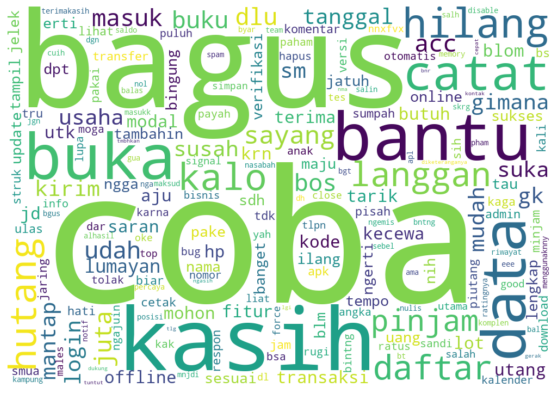

In [148]:
# Generate a word cloud image
wordcloud = WordCloud(
    background_color="white", 
    width = 1000,
    height = 700, 
    collocations=False).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [149]:
app_reviews_bad.loc[(app_reviews_bad['content'].str.contains("coba")), ['content','score']]

,content,score
22,"masih saya coba, dulu kalo lengkap nanti saya kasih bintang 5",3
25,kasih 3 bintang dulu.. mau coba aplikasinya untuk minjam uang,3
202,masih mau coba. kalau bisa sesuai tambah bintang nya,3
242,saya coba dlu bnr apa ngga,2
479,sy belum coba menggunakannya cuman lihat komentar kawan2 plus2 semua tentang aplikasi ini,2
494,mau coba dlu baru pertma kalinya download aplikasi ini klo bagus tak kasi 5 bintang nya nnti,3
526,saya belum tahu tentang credibook saya coba dulu kasih satu bintang.,1
592,"bintang 1 dulu belum di coba, entar aku tambah lagi kalau ini app ok",1
599,coba dulu baru di tambah bintang nya,1
674,uji coba bila bagus siap bintang 5,3


In [75]:
app_reviews_bad.loc[(app_reviews_bad['content'].str.contains("data")), ['content','score']]

,content,score
41,"kaga ngerti nih gua ama aplikasi sumpah,nga jelas..tlng hps smua riwayat data sy terima kasih.",1
100,"kenapa semua data hilang secara tiba2 dgn sendirinya, alhasil semua data yang saya percayakan tanpa menyalin di memory lain yg udah berbulan2 hilang semuanya. kecewa sama aplikasi ini. skrg harus ...",1
263,data hilang sendiri. 😪,1
432,maaf admin untuk pemasukan aja... kalo offline data utang ga bisa dibuka..kalo bisa online or offline selalu stanbay,3
829,"ga perlu takut data hilang , karena 100% data aman di server kita ???????",2
922,gagal di terima....mohon hapus saja data2 saya,1
958,kenapa aplikasi gak bisa di buka jelek . jadi nyesel nyimpan data di credibook rugi banget karna aplikasi jadi ribet. masukan kode mash gak terbuka.,1
1078,kok yang data yang lama hilang....,3
1508,berjelimet bertumpuk..rerlalu kecil tampilannya pembukuan/pendataan lbh pas di pc/laptop,1
1595,data hilang bossss,1


In [151]:
app_reviews_bad.loc[(app_reviews_bad['content'].str.contains("lemot")), ['content','score']]

,content,score
393,udah bagus.. tp skg ko jd agak lemot ya min.. tru klo bisa tambahkan menu untuk reset,3
521,"agak lemot ,ketika di buka aplikasinya",3
1405,tes dulu baru ok lemot ap bagus,3
1527,suka lemot,3


In [152]:
app_reviews_bad.loc[(app_reviews_bad['content'].str.contains("susah")), ['content','score']]

,content,score
164,gimana ini susah masukk,2
826,waduh susah...klo gak ada jaringan mau catet utang plelangan...gk bisa pembaharuan ya...gitu2 aja cman akses cetak struk...,1
883,"knapa mau login lagi lupa kata sandi susah banget..yg diminta kode angka,yg dikasih sama operator huruf...trus dipapan keyboard nggak ada tampilan untuk huruf..kan aneh.dengan terpaksa saya kasih ...",1
1035,aplikasi bagus cukup membantu...tp sayang ga bisa offline.jd kalau kita nagih di daerah susah signal / waktu signal lost sangat kerepotan.mohon ditingkatkan,2


## Good Reviews (rating/score>=4)

In [153]:
# Sample of good reviews
app_reviews_df.loc[app_reviews_df.score>=4,['content','score']].head(20)

,content,score
0,"aplikasi yang sangat bagus dan baik dengan aplikasi credibook mempermudah saya untuk mencatat pemasukan , pengeluaran uang dan barang, bisa mencatat utang dengan mudah dan tidak akan ada lupa uta...",5
1,kalau bisa saat transaksi yg terjadi sekarang. coba lgs tertera tanggal-bulan-tahun. jangan tertulis hari ini. sbb byk konsumen protes . dan katanya sdh bs print lgs . di mana ya. sbb saya tak men...,4
2,"luar biasa aplikasi ini, sangat membantu dlm pencatatan utang piutang dan sangat keren, ayo teman teman gunakan aplikasi ini, smg berjaya selalu, aamiin",5
3,sejauh ini aplikasinya bagus jika di gunakan di beberapa device sinkronnya cepat. masukan dibuatkan akses untuk di web. sehingga jika lagi menggunakan laptop bisa akses di laptop juga gak perlu bu...,5
4,alhamdulilah sejak pake aplk ini cukup membantu cuman sedikit saran seharus nya bisa di buka enak nya bisa di buka juga klu lagi oflaine pasti lebih bagus,5
5,"bisa sejauh ini apikasinya sangat membantu, kami pengguna baru sangat sangat dan sangat propesional.terimakasih bpk/ibu admin",5
6,"saya senang sekali dapat mengenal aplikasi ini. karena benar-benar sangat membantu dan memudahkan saya dalam proses pembukuan. apalagi bagi pemula seperti saya yang baru memulai usaha, aplikasinya...",5
7,"aplikasi credibook adalah pahlawanku fitur yg dimilki oleh aplikasi credibook sangat membantuku dlm mencatat keuanganku, banyak sekali kelebihan dari fitur credibook salh satunya aku dpt menghemat...",5
8,"aplikasi yang bagus, sangat membantu,yang belum download ayok buruan download, rugi kalau gak ikutan download pokok nya, sukses selalu credibook,..",5
9,hp saya realme 3 knp blm update versi 1.9.3 masih di 1.9.2 sedangkan hp yg teman bisa update 1.9.3 soalnya saya butuh cetak struk langsung di pembayaran,5


In [154]:
# put good reviews in new dataframe
app_reviews_good = app_reviews_df[app_reviews_df.score>=4]

### Word Clouds and Data Viz

In [155]:
text = " ".join(review for review in app_reviews_good.processed)
print ("There are {} words in the combination of all review.".format(len(text)))

There are 57380 words in the combination of all review.


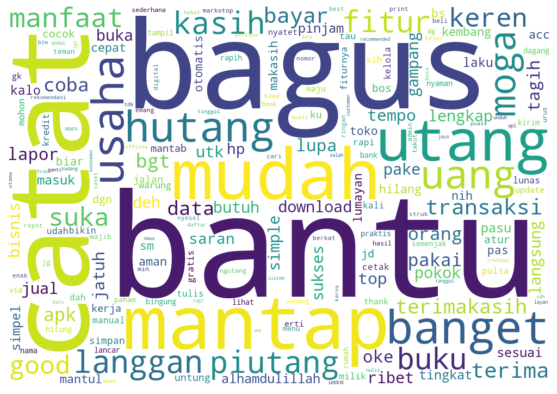

In [156]:
# Generate a word cloud image
wordcloud = WordCloud(
    background_color="white", 
    width = 1000,
    height = 700, 
    collocations=False).generate(text)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()